In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from xgboost import XGBClassifier

# 1. Load full dataset
df = pd.read_csv("/Users/alexlozano/Desktop/DS 3001/Assigments/2019-20_pbp.csv", low_memory=False)

# 2. Filter only valid shot outcomes and map to binary target
print("All unique ShotOutcome values:", df['ShotOutcome'].unique())
df = df[df['ShotOutcome'].isin(['make', 'miss'])]
df['ShotOutcomeBinary'] = (df['ShotOutcome'] == 'make').astype(int)
print("Class balance:\n", df['ShotOutcomeBinary'].value_counts(normalize=True))

# 3. Feature engineering
df['ScoreDifference'] = df['HomeScore'] - df['AwayScore']
df['TimeRemaining'] = df.apply(
    lambda row: (4 - int(row['Quarter'])) * 720 + int(row['SecLeft'])
                if pd.notnull(row['Quarter']) and pd.notnull(row['SecLeft'])
                else np.nan,
    axis=1
)

# 4. Fill missing feature values
for col in ['Shooter', 'ShotType', 'Assister', 'Blocker']:
    df[col] = df[col].fillna('Unknown')
df['ScoreDifference'] = df['ScoreDifference'].fillna(0)
df['TimeRemaining']   = df['TimeRemaining'].fillna(0)

# 5. Define feature matrix X and target y
categorical_features = ['Shooter', 'ShotType', 'Assister', 'Blocker']
numeric_features     = ['ScoreDifference', 'TimeRemaining']
features = categorical_features + numeric_features

X = df[features]
y = df['ShotOutcomeBinary']

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 7. Build preprocessing + XGBoost pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(),                 numeric_features)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        alpha=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# 8. Train the model
pipeline.fit(X_train, y_train)
print(" Model training complete")

# 9. Predict and evaluate
y_pred  = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy: ",    accuracy_score(y_test, y_pred))
print("F1 Score: ",    f1_score(y_test, y_pred))
print("ROC-AUC:  ",    roc_auc_score(y_test, y_proba))
print("Log Loss: ",    log_loss(y_test, y_proba))


All unique ShotOutcome values: [nan 'miss' 'make']
Class balance:
 ShotOutcomeBinary
0    0.540117
1    0.459883
Name: proportion, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Model training complete
Accuracy:  0.829298418972332
F1 Score:  0.78020230294548
ROC-AUC:   0.9144275420574678
Log Loss:  0.3345837654357502


In [235]:
from sklearn.model_selection import RandomizedSearchCV

# Very small search space
param_dist = {
    'xgb__n_estimators':     [100, 200],
    'xgb__max_depth':        [4, 6],
    'xgb__learning_rate':    [0.05, 0.1],
    'xgb__subsample':        [0.8, 1.0],
}

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1,
    random_state=42
)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
best_pipe = rs.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:07:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:07:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best params: {'xgb__subsample': 0.8, 'xgb__n_estimators': 200, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1}


In [238]:
XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,          # Already present, but should tune
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    alpha=0.1,
    booster='gbtree',           # Could tune: ['gbtree', 'dart', 'gblinear']
    use_label_encoder=False,
    eval_metric='logloss',
    nthread=4,                  # Parallel processing!
    random_state=42
)


XGBClassifier(alpha=0.1, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [239]:
param_dist = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__booster': ['gbtree', 'dart']
}


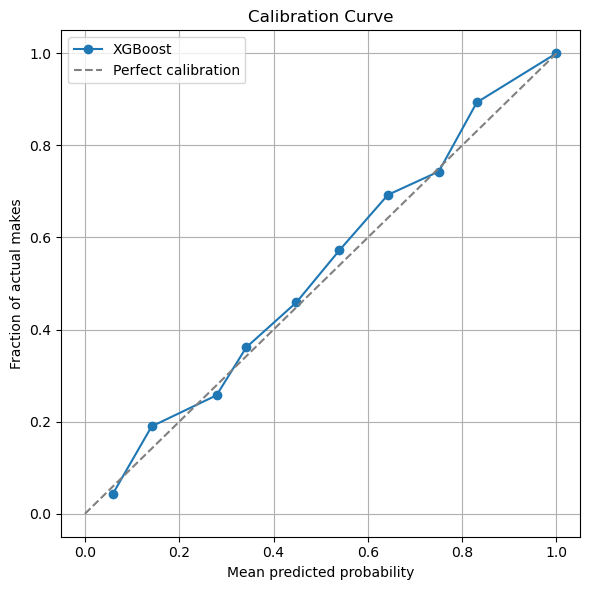

In [240]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_proba = best_pipe.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, 'o-', label='XGBoost')
plt.plot([0,1],[0,1],'--', color='gray', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of actual makes')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


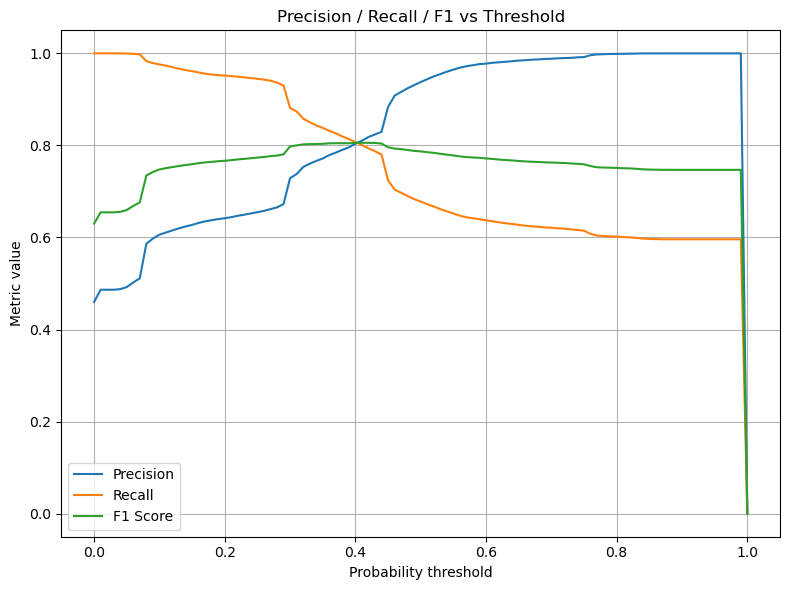

In [241]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

threshs = np.linspace(0,1,101)
precisions, recalls, f1s = [], [], []

for t in threshs:
    y_pred_thresh = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

plt.figure(figsize=(8,6))
plt.plot(threshs, precisions, label='Precision')
plt.plot(threshs, recalls,    label='Recall')
plt.plot(threshs, f1s,        label='F1 Score')
plt.xlabel('Probability threshold')
plt.ylabel('Metric value')
plt.title('Precision / Recall / F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


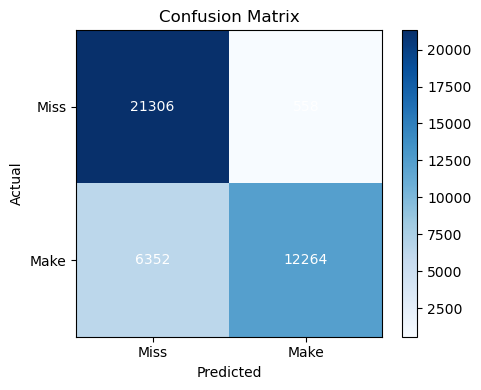

              precision    recall  f1-score   support

        miss       0.77      0.97      0.86     21864
        make       0.96      0.66      0.78     18616

    accuracy                           0.83     40480
   macro avg       0.86      0.82      0.82     40480
weighted avg       0.86      0.83      0.82     40480



In [242]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0,1], ['Miss','Make'])
plt.yticks([0,1], ['Miss','Make'])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', color='white')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['miss','make']))
